Nama : M. Priambodo Satrio Wibowo

Email : satriow110702@gmail.com

sumberdata: https://www.kaggle.com/datasets/emmanuelfwerr/london-weather-data

In [118]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Dense, LSTM, Conv1D, Bidirectional

In [112]:
df = pd.read_csv('https://raw.githubusercontent.com/saatriow/Model-Machine-Learning-dengan-Data-Time-Series/main/london_weather.csv')
df.head

<bound method NDFrame.head of            date  cloud_cover  sunshine  global_radiation  max_temp  mean_temp  \
0      19790101          2.0       7.0              52.0       2.3       -4.1   
1      19790102          6.0       1.7              27.0       1.6       -2.6   
2      19790103          5.0       0.0              13.0       1.3       -2.8   
3      19790104          8.0       0.0              13.0      -0.3       -2.6   
4      19790105          6.0       2.0              29.0       5.6       -0.8   
...         ...          ...       ...               ...       ...        ...   
15336  20201227          1.0       0.9              32.0       7.5        7.5   
15337  20201228          7.0       3.7              38.0       3.6        1.1   
15338  20201229          7.0       0.0              21.0       4.1        2.6   
15339  20201230          6.0       0.4              22.0       5.6        2.7   
15340  20201231          7.0       1.3              34.0       1.5       -0.8  

In [113]:
df = df.drop(columns=[
    'cloud_cover', 'sunshine', 'global_radiation', 'precipitation','pressure',
    'snow_depth'
])
df.head

<bound method NDFrame.head of            date  max_temp  mean_temp  min_temp
0      19790101       2.3       -4.1      -7.5
1      19790102       1.6       -2.6      -7.5
2      19790103       1.3       -2.8      -7.2
3      19790104      -0.3       -2.6      -6.5
4      19790105       5.6       -0.8      -1.4
...         ...       ...        ...       ...
15336  20201227       7.5        7.5       7.6
15337  20201228       3.6        1.1      -1.3
15338  20201229       4.1        2.6       1.1
15339  20201230       5.6        2.7      -0.1
15340  20201231       1.5       -0.8      -3.1

[15341 rows x 4 columns]>

In [114]:
df.isnull().sum()

date          0
max_temp      6
mean_temp    36
min_temp      2
dtype: int64

In [115]:
df.dropna(subset=['max_temp'],inplace=True)
df.dropna(subset=['mean_temp'],inplace=True)
df.dropna(subset=['min_temp'],inplace=True)
df.isnull().sum()

date         0
max_temp     0
mean_temp    0
min_temp     0
dtype: int64

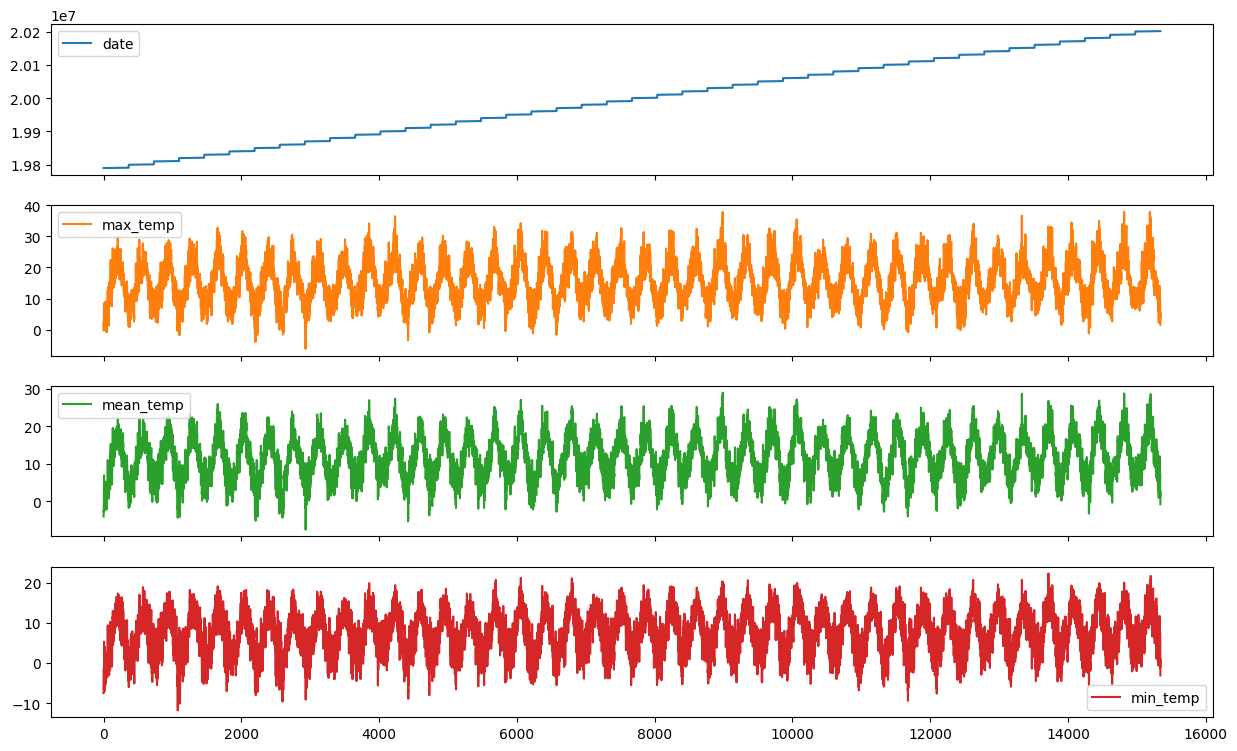

In [116]:
df_plot = df
df_plot[df_plot.columns.to_list()].plot(subplots=True, figsize=(15, 9))
plt.show()

date           int64
max_temp     float64
mean_temp    float64
min_temp     float64
dtype: object

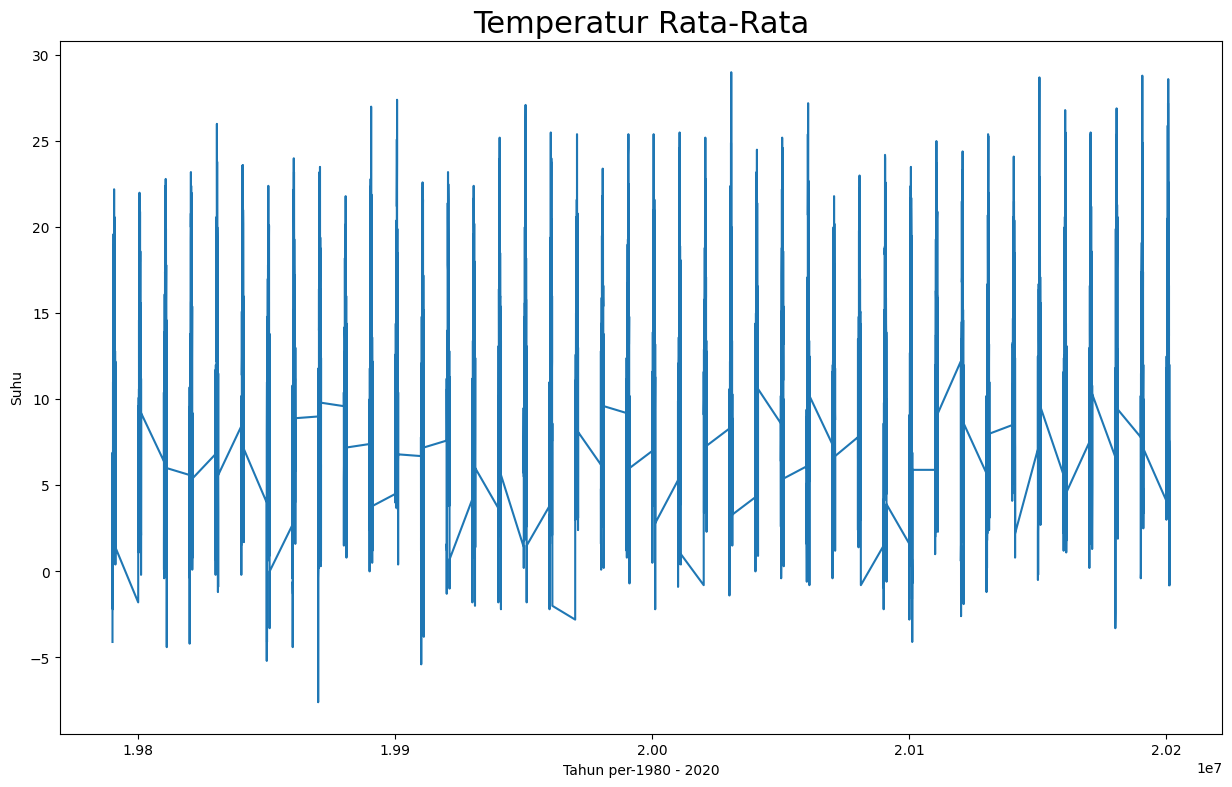

In [117]:
date = df['date'].values
suhu = df['mean_temp'].values

date = np.array(date)
suhu = np.array(suhu)

plt.figure(figsize=(15,9))
plt.plot(date, suhu)

plt.title('Temperatur Rata-Rata', fontsize = 22)
plt.ylabel('Suhu')
plt.xlabel('Tahun per-1980 - 2020')

df.dtypes

#### split data

In [100]:
x_train, x_valid, y_train, y_valid = train_test_split(suhu, date, test_size=0.2, shuffle=False)

print('Total Data Train : ', len(x_train))
print('Total Data Validation : ', len(x_valid))

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w : w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w : (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

Jumlah Data Train :  12244
Jumlah Data Validation :  3061


In [120]:
train_set = windowed_dataset(
    x_train,
    window_size=60,
    batch_size=100,
    shuffle_buffer=1000
)

val_set = windowed_dataset(
    x_valid,
    window_size=60,
    batch_size=100,
    shuffle_buffer=1000
)

model = tf.keras.models.Sequential([
        Conv1D(filters=32, kernel_size=5, padding='causal', activation='relu', input_shape=[1, 1]),
        Bidirectional(LSTM(32, return_sequences=True)),
        Bidirectional(LSTM(32, return_sequences=True)),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(1)
])

In [121]:
Mae = (df['mean_temp'].max() - df['mean_temp'].min()) * 10/100
print(Mae)

3.66


In [122]:

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < Mae and logs.get('val_mae') < Mae):
      print("\nNilai MAE mencapai <10% skala data")
      self.model.stop_training=True

callbacks = myCallback()

In [123]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)

model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mae"]
)

history = model.fit(
    train_set,
    epochs=100,
    validation_data=val_set,
    verbose=2,
    callbacks=[callbacks]
)

Epoch 1/100
122/122 - 65s - loss: 9.4916 - mae: 9.9856 - val_loss: 8.4280 - val_mae: 8.9204 - 65s/epoch - 530ms/step
Epoch 2/100
122/122 - 58s - loss: 5.7297 - mae: 6.2124 - val_loss: 4.2149 - val_mae: 4.6936 - 58s/epoch - 479ms/step
Epoch 3/100
122/122 - 53s - loss: 3.8011 - mae: 4.2787 - val_loss: 3.6609 - val_mae: 4.1363 - 53s/epoch - 435ms/step
Epoch 4/100

Nilai MAE mencapai <10% skala data
122/122 - 56s - loss: 3.1886 - mae: 3.6599 - val_loss: 2.8816 - val_mae: 3.3492 - 56s/epoch - 460ms/step


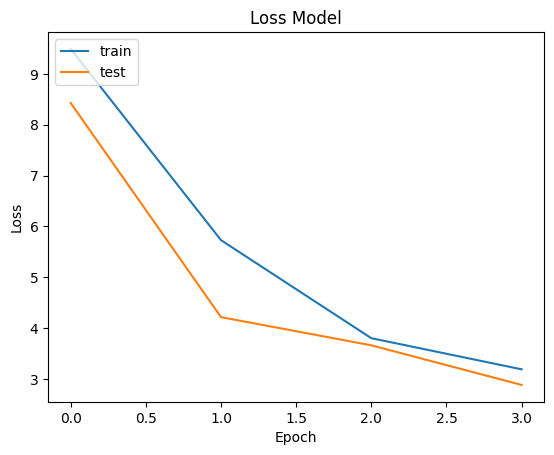

In [124]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

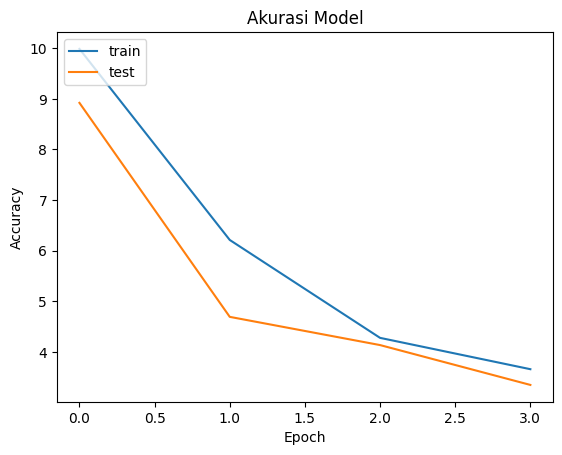

In [125]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Akurasi Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
